In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import random
import pickle
import sys
import networkx as nx
from definitions import get_node_color, get_node_id
sys.path.append("./..")
from soft_wl_subtree import Soft_WL_Subtree

## Load fitted soft wl subtree kernel

In [2]:
if os.path.exists("fitted_soft_wl_subtree.pkl"):
    print("There is a pre-fitted soft wl subtree kernel. We will load it directly.")
    with open("fitted_soft_wl_subtree.pkl", "rb") as f:
        soft_wl_subtree_ = pickle.load(f)
else:
    print("There is no pre-fitted soft wl subtree kernel.")
    print("Go run `python 3_fit_wl_subtree_kernel.py` instead")

There is a pre-fitted soft wl subtree kernel. We will load it directly.


In [3]:
Similarity_matrix = soft_wl_subtree_.Similarity_matrix
Patient_Ids = [cellular_graph[0] for cellular_graph in soft_wl_subtree_.X]
print("The shape of the similarity matrix is", Similarity_matrix.shape)
print("There are {} patients".format(len(Patient_Ids)))

The shape of the similarity matrix is (379, 379)
There are 379 patients


## Demonstrate inter-patient similarity

In [4]:
# Load single cell data
cells = pd.read_csv('Datasets/Danenberg_et_al/cells.csv') 
cells['cellTypeID'] = cells['meta_description'].map(get_node_id('Danenberg', 'CellType') )
patientID_colname = "metabric_id"
imageID_colname = "ImageNumber"
celltypeID_colname = "cellTypeID"
coorX_colname = "Location_Center_X"
coorY_colname = "Location_Center_Y"
cells = cells.rename(
            columns={
                patientID_colname: "patientID",
                imageID_colname: "imageID",
                celltypeID_colname: "celltypeID",
                coorX_colname: "coorX",
                coorY_colname: "coorY",
            }
        )

### (1) Choose a template patient

In [5]:
template_patient_id = 'MB-0882'
template_image_id = 50

In [6]:
adj = soft_wl_subtree_.X[Patient_Ids.index(template_patient_id)][1] # The adjacency matrix of the template patient

cells_ = cells[cells['imageID'] == template_image_id].reset_index(drop=True)
assert len(cells_) == adj.shape[0]
print("The number of cells in the template patient is", len(cells_))

The number of cells in the template patient is 2118


In [7]:
def get_pos(G):
    x = nx.get_node_attributes(G, "coorX")
    y = nx.get_node_attributes(G, "coorY")
    pos = {}
    for key, _ in x.items():
        pos[key] = (x[key], y[key])
    return pos
# For visualization propose, we set the diagonal of the adjacency matrix to be 0
np.fill_diagonal(adj, 0) # Remove self loops
# For visualization purpose, we only show edges with a weight higher than 0.01
adj[adj < 0.01] = 0
G = nx.from_numpy_array(adj)
nx.set_node_attributes(G, cells_["coorX"], "coorX")
nx.set_node_attributes(G, cells_["coorY"], "coorY")
nx.set_node_attributes(G, cells_["meta_description"], "meta_description")

#### Fig.5.a  The cellular graph of a selected patient, referred to as the ”template patient”.

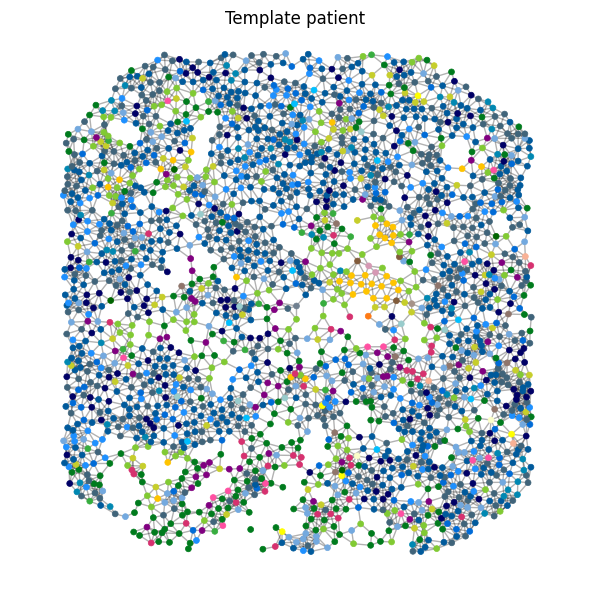

In [8]:
f, ax = plt.subplots(
    1,
    1,
    figsize=(6, 6),
    tight_layout=True,
)
cell_color_dict = get_node_color("Danenberg", "CellType")
nx.draw_networkx_nodes(
    G,
    get_pos(G),
    node_size=18,
    node_color=[
        cell_color_dict[cell_type]
        for cell_type in list(nx.get_node_attributes(G, "meta_description").values())
    ],
    # edgecolors="black",
    linewidths=0.5,
    ax=ax,
)
nx.draw_networkx_edges(G, get_pos(G), ax=ax, alpha=0.3, width=1)
ax.set(
    title = "Template patient",
    xlim=(
        (max(cells_["coorX"]) - min(cells_["coorX"])) / 2 - 350,
        (max(cells_["coorX"]) - min(cells_["coorX"])) / 2 + 350,
    ),
    ylim=(
        (max(cells_["coorY"]) - min(cells_["coorY"])) / 2 - 350,
        (max(cells_["coorY"]) - min(cells_["coorY"])) / 2 + 350,
    ),
)
ax.set_axis_off()

### (2) Plot the sorted similarity to template patient

In [9]:
template_patient_index = Patient_Ids.index(template_patient_id) # The index of the template patient in the similarity matrix
Similarities_sorted = np.sort(Similarity_matrix[template_patient_index, :])[::-1] # Sort the similarities in descending order

### Fig.5.b The similarity scores of other patients compared to the template patient (x-axis: patient ranking; y-axis: similarity score).

Patient ID: MB-0598 Similarity: 0.9890441791256402 Rank: 1
Patient ID: MB-0317 Similarity: 0.7910475916256207 Rank: 17
Patient ID: MB-0269 Similarity: 0.13636467320712234 Rank: 74


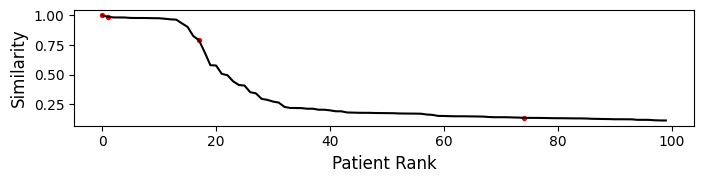

In [10]:
Representative_patient_ids = ['MB-0262', 'MB-0356', 'MB-0290']
f, ax = plt.subplots(figsize=(8, 1.5))
ax.plot(Similarities_sorted[:100], color="k")
# TEMPLATE PATIENT
ax.scatter(0, Similarities_sorted[0], color="red", s=8)
# REPRESENTATIVE PATIENTS
Representative_patient_indices = (
    Patient_Ids.index(Representative_patient_ids[0]),
    Patient_Ids.index(Representative_patient_ids[1]),
    Patient_Ids.index(Representative_patient_ids[2]),
)
Patient_indices_sorted = np.argsort(Similarity_matrix[template_patient_index, :])[::-1]
Representative_patient_rankings = [
    list(Patient_indices_sorted).index(i) for i in Representative_patient_indices
]
for indice in Representative_patient_rankings:
    ax.scatter(indice, Similarities_sorted[indice], color="red", s=8)
    print("Patient ID:", Patient_Ids[indice], "Similarity:", Similarities_sorted[indice], "Rank:", indice)
ax.set_xlabel("Patient Rank", fontsize=12)
ax.set_ylabel("Similarity", fontsize=12)
plt.show()

### (3) Show representative examples

#### Representative example 1: MB-0262

In [11]:
patient_id = "MB-0262"
image_id = cells[cells["patientID"] == patient_id]["imageID"].values[0]
print("The image ID of the patient", patient_id, "is", image_id)

The image ID of the patient MB-0262 is 145


In [12]:
adj = soft_wl_subtree_.X[Patient_Ids.index(patient_id)][1] # The adjacency matrix of the template patient
cells_ = cells[cells['imageID'] == image_id].reset_index(drop=True)
assert len(cells_) == adj.shape[0]
print("The number of cells in the template patient is", len(cells_))
np.fill_diagonal(adj, 0) # Remove self loops
adj[adj < 0.01] = 0
G = nx.from_numpy_array(adj)
nx.set_node_attributes(G, cells_["coorX"], "coorX")
nx.set_node_attributes(G, cells_["coorY"], "coorY")
nx.set_node_attributes(G, cells_["meta_description"], "meta_description")

The number of cells in the template patient is 1652


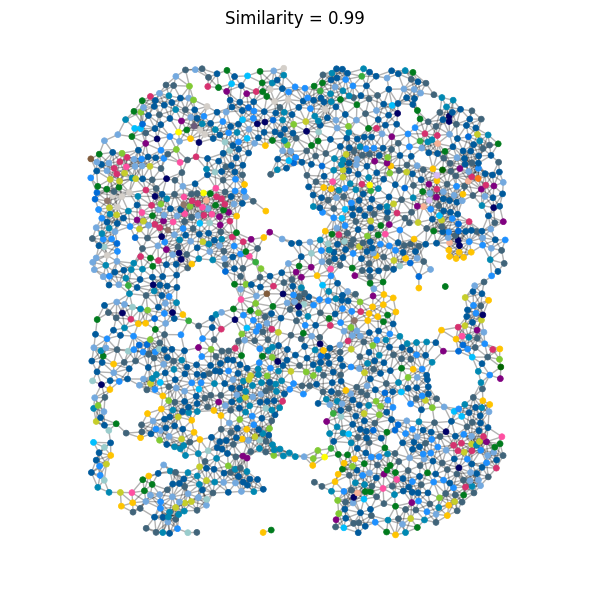

In [13]:
f, ax = plt.subplots(
    1,
    1,
    figsize=(6, 6),
    tight_layout=True,
)
cell_color_dict = get_node_color("Danenberg", "CellType")
nx.draw_networkx_nodes(
    G,
    get_pos(G),
    node_size=18,
    node_color=[
        cell_color_dict[cell_type]
        for cell_type in list(nx.get_node_attributes(G, "meta_description").values())
    ],
    # edgecolors="black",
    linewidths=0.5,
    ax=ax,
)
nx.draw_networkx_edges(G, get_pos(G), ax=ax, alpha=0.3, width=1)
ax.set(
    title = 'Similarity = {:.2f}'.format(Similarity_matrix[template_patient_index, Patient_Ids.index(patient_id)]),
    xlim=(
        (max(cells_["coorX"]) - min(cells_["coorX"])) / 2 - 350,
        (max(cells_["coorX"]) - min(cells_["coorX"])) / 2 + 350,
    ),
    ylim=(
        (max(cells_["coorY"]) - min(cells_["coorY"])) / 2 - 350,
        (max(cells_["coorY"]) - min(cells_["coorY"])) / 2 + 350,
    ),
)
ax.set_axis_off()

#### Representative example 2: MB-0356

In [14]:
patient_id = "MB-0356"
image_id = cells[cells["patientID"] == patient_id]["imageID"].values[0]
print("The image ID of the patient", patient_id, "is", image_id)

The image ID of the patient MB-0356 is 41


In [15]:
adj = soft_wl_subtree_.X[Patient_Ids.index(patient_id)][1] # The adjacency matrix of the template patient
cells_ = cells[cells['imageID'] == image_id].reset_index(drop=True)
assert len(cells_) == adj.shape[0]
print("The number of cells in the template patient is", len(cells_))
np.fill_diagonal(adj, 0) # Remove self loops
adj[adj < 0.01] = 0
G = nx.from_numpy_array(adj)
nx.set_node_attributes(G, cells_["coorX"], "coorX")
nx.set_node_attributes(G, cells_["coorY"], "coorY")
nx.set_node_attributes(G, cells_["meta_description"], "meta_description")


The number of cells in the template patient is 1244


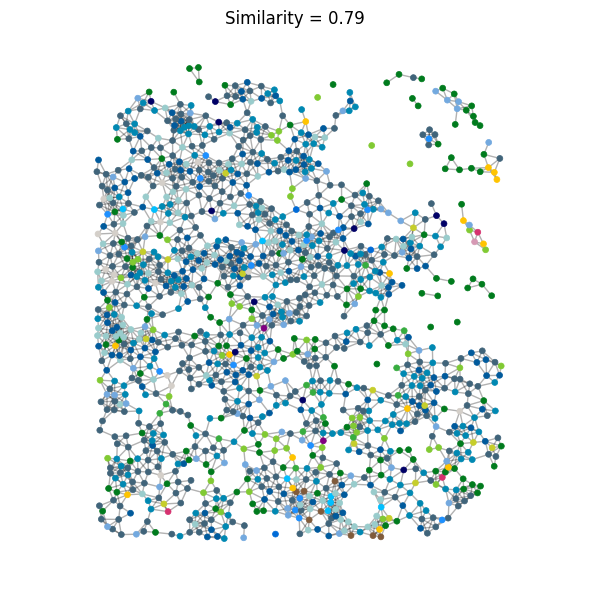

In [16]:
f, ax = plt.subplots(
    1,
    1,
    figsize=(6, 6),
    tight_layout=True,
)
cell_color_dict = get_node_color("Danenberg", "CellType")
nx.draw_networkx_nodes(
    G,
    get_pos(G),
    node_size=18,
    node_color=[
        cell_color_dict[cell_type]
        for cell_type in list(nx.get_node_attributes(G, "meta_description").values())
    ],
    # edgecolors="black",
    linewidths=0.5,
    ax=ax,
)
nx.draw_networkx_edges(G, get_pos(G), ax=ax, alpha=0.3, width=1)
ax.set(
    title = 'Similarity = {:.2f}'.format(Similarity_matrix[template_patient_index, Patient_Ids.index(patient_id)]),
    xlim=(
        (max(cells_["coorX"]) - min(cells_["coorX"])) / 2 - 350,
        (max(cells_["coorX"]) - min(cells_["coorX"])) / 2 + 350,
    ),
    ylim=(
        (max(cells_["coorY"]) - min(cells_["coorY"])) / 2 - 350,
        (max(cells_["coorY"]) - min(cells_["coorY"])) / 2 + 350,
    ),
)
ax.set_axis_off()


#### Representaive example 3: MB-0290

In [17]:
patient_id = "MB-0290"
image_id = cells[cells["patientID"] == patient_id]["imageID"].values[0]
print("The image ID of the patient", patient_id, "is", image_id)


The image ID of the patient MB-0290 is 199


In [18]:
adj = soft_wl_subtree_.X[Patient_Ids.index(patient_id)][1] # The adjacency matrix of the template patient
cells_ = cells[cells['imageID'] == image_id].reset_index(drop=True)
assert len(cells_) == adj.shape[0]
print("The number of cells in the template patient is", len(cells_))
np.fill_diagonal(adj, 0) # Remove self loops
adj[adj < 0.01] = 0
G = nx.from_numpy_array(adj)
nx.set_node_attributes(G, cells_["coorX"], "coorX")
nx.set_node_attributes(G, cells_["coorY"], "coorY")
nx.set_node_attributes(G, cells_["meta_description"], "meta_description")


The number of cells in the template patient is 1348


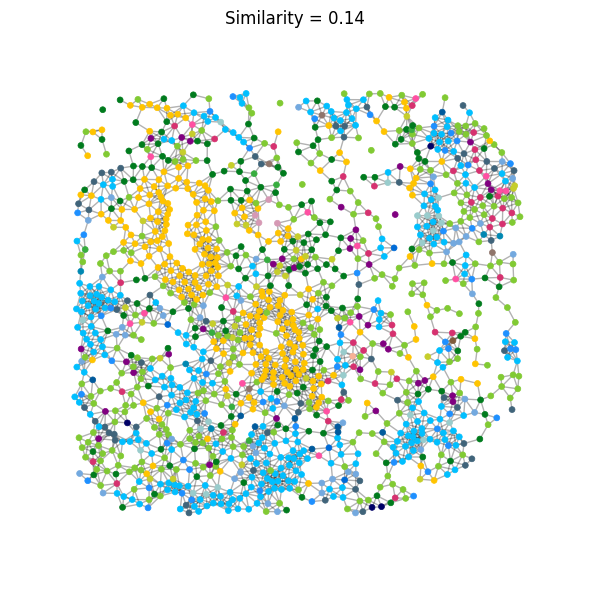

In [19]:
f, ax = plt.subplots(
    1,
    1,
    figsize=(6, 6),
    tight_layout=True,
)
cell_color_dict = get_node_color("Danenberg", "CellType")
nx.draw_networkx_nodes(
    G,
    get_pos(G),
    node_size=18,
    node_color=[
        cell_color_dict[cell_type]
        for cell_type in list(nx.get_node_attributes(G, "meta_description").values())
    ],
    # edgecolors="black",
    linewidths=0.5,
    ax=ax,
)
nx.draw_networkx_edges(G, get_pos(G), ax=ax, alpha=0.3, width=1)
ax.set(
    title = 'Similarity = {:.2f}'.format(Similarity_matrix[template_patient_index, Patient_Ids.index(patient_id)]),
    xlim=(
        (max(cells_["coorX"]) - min(cells_["coorX"])) / 2 - 350,
        (max(cells_["coorX"]) - min(cells_["coorX"])) / 2 + 350,
    ),
    ylim=(
        (max(cells_["coorY"]) - min(cells_["coorY"])) / 2 - 350,
        (max(cells_["coorY"]) - min(cells_["coorY"])) / 2 + 350,
    ),
)
ax.set_axis_off()